In [1]:
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

/Users/luccazimmermann/anaconda3/envs/exotrojans/lib/python3.14/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


In [2]:
raw_data = pd.read_csv('tess_confirmed.csv', comment='#')

df = raw_data[
    raw_data['pl_orbper'].notna() &          # period not NaN
    raw_data['pl_tranmid'].notna() &         # transit midtime not NaN
    (raw_data['sy_vmag'] < 12) &             # TESS mag < 10
    (raw_data['pl_rade'] > 6)              # > 6 Earth radii
]

tics    = df['tic_id'].to_numpy()
pers    = df['pl_orbper'].to_numpy()
t0s_bjd = df['pl_tranmid'].to_numpy()
t0s     = t0s_bjd - 2457000

In [ ]:
num=100
#fig, ax = plt.subplots(1, 1)

for i in range(num):
    fig, ax = plt.subplots(1, 1)

    tic = tics[i]
    per = pers[i]
    t0 = t0s[i]
    lc = lk.search_lightcurve(tic, author='TESS-SPOC')[0].download()
    if lc is None:
        continue

    folded = lc.normalize().fold(period=per, epoch_time=t0, wrap_phase=0.5)
    binned = folded.bin(bins=10000)
    phase_deg = (binned.phase.value / per) * 360.0
    ax.scatter(phase_deg, binned.flux.value, s=1)


    plt.xlim(-100, 100)
    plt.ylim(.995, 1.005)
    plt.axvline(60, color='gray', linestyle='--')
    plt.axvline(-60, color='gray', linestyle='--')

plt.xlabel('Phase (°)')
plt.ylabel('Normalized Flux')
plt.title(f'Stacked Light Curves of {num} Exoplanets')
plt.show()

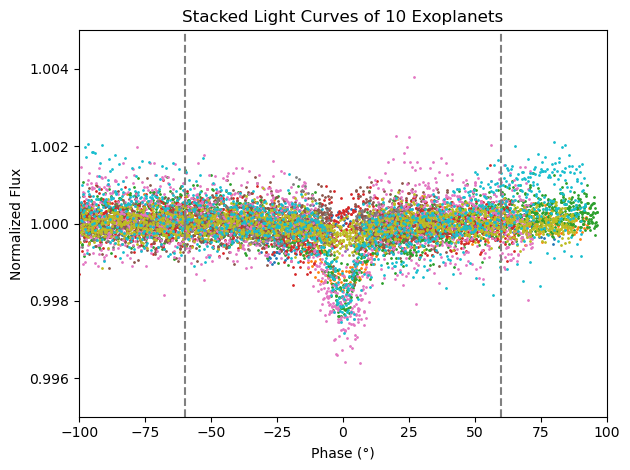

In [ ]:
fig, ax = plt.subplots(1, 1)
num=50

for i in range(num):


    tic = tics[i]
    per = pers[i]
    t0 = t0s[i]
    lc = lk.search_lightcurve(f'TIC {str(tic)}', author='TESS-SPOC')[0].download()
    if lc is None:
        continue

    folded = lc.normalize().fold(period=per, epoch_time=t0, wrap_phase=0.5).remove_outliers()
    binned = folded.bin(bins=10000)
    phase_deg = (binned.phase.value / per) * 360.0
    ax.scatter(phase_deg, binned.flux.value, s=1)


    plt.xlim(-100, 100)
    plt.ylim(.995, 1.005)
    plt.axvline(60, color='gray', linestyle='--')
    plt.axvline(-60, color='gray', linestyle='--')

plt.xlabel('Phase (°)')
plt.ylabel('Normalized Flux')
plt.title(f'Stacked Light Curves of {num} Exoplanets')
plt.show()

In [85]:
len(tics)

146

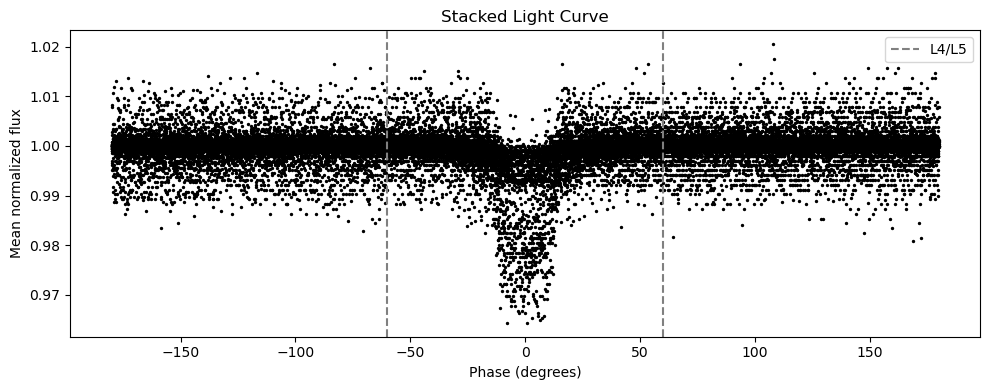

In [125]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt

# How many planets to try
num = len(tics)        # avoid index error

# Phase grid in *cycles*  (-0.5 to +0.5)
phase_edges   = np.linspace(-0.5, 0.5, 100001)   # 1000 bins
phase_centers = 0.5 * (phase_edges[1:] + phase_edges[:-1])
n_bins        = len(phase_centers)

sum_flux  = np.zeros(n_bins)
sum_count = np.zeros(n_bins)

for i in range(num):
    tic = tics[i]
    per = pers[i]
    t0  = t0s[i]

    res = lk.search_lightcurve(tic, author="TESS-SPOC")
    if len(res) == 0:
        continue

    lc = res[0].download()
    if lc is None:
        continue

    # Fold: lightkurve uses time = phase in cycles in [-0.5, 0.5]
    folded = lc.normalize().fold(period=per, epoch_time=t0, wrap_phase=0.5).remove_outliers()

    phase = folded.time.value      # cycles
    flux  = folded.flux.value

    # Drop NaNs
    m = np.isfinite(phase) & np.isfinite(flux)
    phase, flux = phase[m], flux[m]

    # --------- SIMPLE QUALITY CUT ("bad planets") ---------
    # # Define in-transit and out-of-transit windows in phase
    # in_tr  = np.abs(phase) < 0.1      # around 0
    # out_tr = np.abs(phase) > 0.20      # far from transit
    #
    # if out_tr.sum() < 50 or in_tr.sum() < 10:
    #     # not enough points, skip this planet
    #     continue
    #
    # depth     = np.median(flux[out_tr]) - np.median(flux[in_tr])
    # sigma_oot = np.std(flux[out_tr])
    # snr_tr    = depth / sigma_oot if sigma_oot > 0 else 0.0
    #
    # if (depth <= 0) or (snr_tr < 3):
    #     # no clear transit or very low SNR -> skip
    #     continue
    # -----------------------------------------------------

    # Bin this planet's points onto the common phase grid
    # Use np.histogram to get sum of flux and counts per bin
    bin_sum,   _ = np.histogram(phase, bins=phase_edges, weights=flux)
    bin_count, _ = np.histogram(phase, bins=phase_edges)

    sum_flux  += bin_sum
    sum_count += bin_count

# Final stacked flux
good = sum_count > 0
stacked_flux = np.full(n_bins, np.nan)
stacked_flux[good] = sum_flux[good] / sum_count[good]

# For plotting in degrees (optional)
phase_deg = phase_centers * 360.0

plt.figure(figsize=(10,4))
plt.scatter(phase_deg[good], stacked_flux[good], s=2, color ='black')
#plt.xlim(-100, 100)
#plt.ylim(0.99, 1.005)
plt.axvline(-60, color='gray', ls='--', label='L4/L5')
plt.axvline( 60, color='gray', ls='--')
plt.legend()
plt.xlabel("Phase (degrees)")
plt.ylabel("Mean normalized flux")
plt.title(f"Stacked Light Curve")
plt.tight_layout()
plt.show()

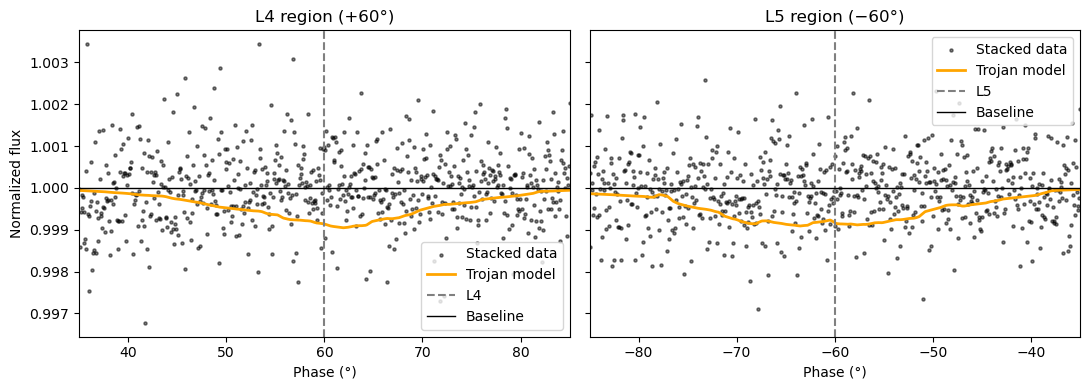

In [115]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
import batman

# -------------------------------
# 1. REAL STACKED LIGHT CURVE
# -------------------------------
# Assumes you already have arrays: tics, pers, t0s

num = len(tics)        # how many planets

# Phase grid in *cycles*  (-0.5 to +0.5)
phase_edges   = np.linspace(-0.5, 0.5, 5001)
phase_centers = 0.5 * (phase_edges[1:] + phase_edges[:-1])
n_bins        = len(phase_centers)

sum_flux  = np.zeros(n_bins)
sum_count = np.zeros(n_bins)

for i in range(num):
    tic = tics[i]
    per = pers[i]
    t0  = t0s[i]

    res = lk.search_lightcurve(tic, author="TESS-SPOC")
    if len(res) == 0:
        continue

    lc = res[0].download()
    if lc is None:
        continue

    # Fold: lightkurve uses phase in cycles in [-0.5, 0.5]
    folded = (
        lc.normalize()
          .fold(period=per, epoch_time=t0, wrap_phase=0.5)
          .remove_outliers()
    )

    phase = folded.time.value      # cycles
    flux  = folded.flux.value

    # Drop NaNs
    m = np.isfinite(phase) & np.isfinite(flux)
    phase, flux = phase[m], flux[m]

    # Bin this planet's points onto the common phase grid
    bin_sum,   _ = np.histogram(phase, bins=phase_edges, weights=flux)
    bin_count, _ = np.histogram(phase, bins=phase_edges)

    sum_flux  += bin_sum
    sum_count += bin_count

# Final stacked flux
good_bins = sum_count > 0
stacked_flux = np.full(n_bins, np.nan)
stacked_flux[good_bins] = sum_flux[good_bins] / sum_count[good_bins]

# Phase in degrees for the stacked curve
phase_deg_stack = phase_centers * 360.0

# -------------------------------
# 2. TROJAN-ONLY MODEL (BATMAN)
# -------------------------------
np.random.seed(1)

# --- System + time grid ---
P, t0 = 5.0, 0.0           # days, reference mid-transit
a_rs, inc = 12.0, 88.5     # a/R*, inclination (deg)
u1, u2 = 0.3, 0.2          # limb darkening
rp_p = 0.08                # planet radius ratio
exp_time = 600/86400       # 10 min in days
supersample = 9
t = np.linspace(t0 - 1.5*P, t0 + 1.5*P, 40000)

def mk_params(t0_here, rp_here):
    p = batman.TransitParams()
    p.t0 = t0_here
    p.per = P
    p.rp = rp_here
    p.a = a_rs
    p.inc = inc
    p.ecc = 0.0
    p.w = 90.0
    p.limb_dark = "quadratic"
    p.u = [u1, u2]
    return p

# --- Planet-only model ---
pp = mk_params(t0, rp_p)
mp = batman.TransitModel(pp, t, supersample_factor=supersample, exp_time=exp_time)
flux_planet = mp.light_curve(pp)

# --- Piecewise L4 Trojan size distribution (Dmin, Dmax, b) ---
segments = np.array([
    [ 2.0,  5.0, 1.3],   # 2–5 km,  b = 1.3
    [ 5.0, 10.0, 2.4],   # 5–10 km, b = 2.4
    [10.0, 93.0, 2.0],   # 10–93 km, b = 2.0
])

def sample_L4_diameters(n):
    Dmin, Dmax, b = segments.T
    q = b + 1.0                       # differential slope
    e = 1.0 - q
    # segment weights ∝ ∫ D^{-q} dD
    I = (Dmax**e - Dmin**e) / e
    p = I / I.sum()
    seg = np.random.choice(len(segments), size=n, p=p)
    D = np.empty(n)
    for i in range(len(segments)):
        m = (seg == i)
        if not m.any():
            continue
        Di, Dx, bi = segments[i]
        qi = bi + 1.0
        ei = 1.0 - qi
        u = np.random.rand(m.sum())
        Di_e, Dx_e = Di**ei, Dx**ei
        D[m] = (u*(Dx_e - Di_e) + Di_e)**(1.0/ei)
    return D

# --- Trojan swarm geometry + sizes ---
N_swarm, frac_L4, sigma_deg = 10000, 0.5, 10.0
nL4 = int(N_swarm * frac_L4)
nL5 = N_swarm - nL4

angles = np.concatenate([
    np.random.normal( 60.0, sigma_deg, nL4),   # around L4
    np.random.normal(-60.0, sigma_deg, nL5),   # around L5
])

D_km = sample_L4_diameters(N_swarm)           # piecewise power law in D
R_troj = D_km / 2.0
# rescale to keep relative distribution but make transits visible
rp_T = (R_troj / R_troj.max()) * 0.01

dt = (angles / 360.0) * P
t0_T = t0 + dt

# Start from planet-only flux, then multiply in trojan dips
flux_combined = flux_planet.copy()
for t0_i, rp_i in zip(t0_T, rp_T):
    pT = mk_params(t0_i, rp_i)
    mT = batman.TransitModel(pT, t, supersample_factor=supersample, exp_time=exp_time)
    flux_combined *= mT.light_curve(pT)

# --- Isolate Trojan-only signal (divide out planet) ---
trojan_only_flux = flux_combined / flux_planet
# Normalize to baseline ~1
trojan_only_flux /= np.median(trojan_only_flux)

phase_deg_model = (t - t0) / P * 360.0

# -------------------------------
# 3. OVERPLOT + ZOOM ON L4/L5
# -------------------------------
width = 50.0  # degrees width around each Lagrange point (adjust to taste)

# Masks for stacked data
mask_L4_stack = (phase_deg_stack >=  60 - width/2) & (phase_deg_stack <=  60 + width/2) & good_bins
mask_L5_stack = (phase_deg_stack >= -60 - width/2) & (phase_deg_stack <= -60 + width/2) & good_bins

# Masks for model
mask_L4_model = (phase_deg_model >=  60 - width/2) & (phase_deg_model <=  60 + width/2)
mask_L5_model = (phase_deg_model >= -60 - width/2) & (phase_deg_model <= -60 + width/2)

fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=True)

# ---- L4 (+60°) region ----
ax = axes[0]
ax.scatter(phase_deg_stack[mask_L4_stack],
           stacked_flux[mask_L4_stack],
           s=5, alpha=0.5, label="Stacked data", color='black')
ax.plot(phase_deg_model[mask_L4_model],
        trojan_only_flux[mask_L4_model],
        lw=2, label="Trojan model", color='orange')

ax.axvline(60, color="gray", ls="--", label="L4")
ax.axhline(1.0, color="black", lw=1, label="Baseline")
ax.set_xlim(60 - width/2, 60 + width/2)
ax.set_xlabel("Phase (°)")
ax.set_ylabel("Normalized flux")
ax.set_title("L4 region (+60°)")
ax.legend()

# ---- L5 (−60°) region ----
ax = axes[1]
ax.scatter(phase_deg_stack[mask_L5_stack],
           stacked_flux[mask_L5_stack],
           s=5, alpha=0.5, label="Stacked data", color='black')
ax.plot(phase_deg_model[mask_L5_model],
        trojan_only_flux[mask_L5_model],
        lw=2, label="Trojan model", color='orange')

ax.axvline(-60, color="gray", ls="--", label="L5")
ax.axhline(1.0, color="black", lw=1, label="Baseline")
ax.set_xlim(-60 - width/2, -60 + width/2)
ax.set_xlabel("Phase (°)")
ax.set_title("L5 region (−60°)")
ax.legend()

plt.tight_layout()
plt.show()

/Users/luccazimmermann/anaconda3/envs/exotrojans/lib/python3.14/site-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 5 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


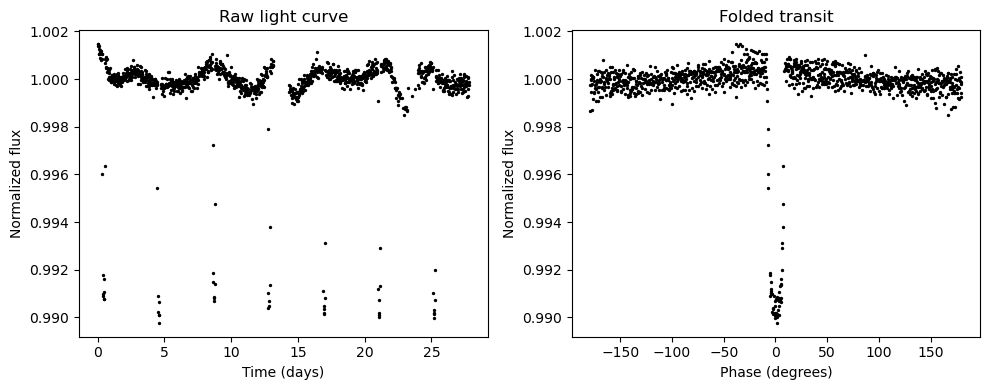

In [110]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np

# choose which planet to show
idx = 4  # change to 1, 2, ... to try others

tic = tics[idx]
per = pers[idx]
t0  = t0s[idx]

# download and normalize the SPOC light curve
lc = lk.search_lightcurve(tic, author="TESS-SPOC").download()
lc = lc.normalize()

# make a folded version
folded = lc.fold(period=per, epoch_time=t0, wrap_phase=0.5, normalize_phase=True)

# raw time in days (shifted so it starts near zero for prettier axis)
time_raw = lc.time.value
time_raw = time_raw - time_raw.min()

# folded phase in cycles and degrees
phase   = folded.time.value               # [-0.5, 0.5]
phase_deg = phase * 360.0

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# ---- left: raw unfolded light curve ----
axes[0].scatter(time_raw, lc.flux.value, s=2, color='black')
axes[0].set_xlabel("Time (days)")
axes[0].set_ylabel("Normalized flux")
axes[0].set_title(f"Raw light curve")

# ---- right: folded transit ----
axes[1].scatter(phase_deg, folded.flux.value, s=2, color='black')
axes[1].set_xlabel("Phase (degrees)")
axes[1].set_ylabel("Normalized flux")
axes[1].set_title(f"Folded transit")
#axes[1].axvline(0, color="k", ls="--", lw=1)

plt.tight_layout()
plt.show()